##<b> Image Classification using Neural Networks</b>

Here we will build a neural network image classifier from scratch and plot the accuracy and loss curves to evaluate the performance

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q "/content/drive/MyDrive/code_files/fiverr/gokalp/dataset1.zip"

In [3]:
!pip install tensorboardX
from tensorboardX import SummaryWriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 1.4 MB/s eta 0:00:00


In [4]:
from tensorboardX import SummaryWriter
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
writer = SummaryWriter()

# Loading the data from the directories
def load_data_from_directory(dirs):
    """
    Charge et normalise des images à partir d'un ensemble de répertoires donnés.

    :param dirs: Liste des chemins des répertoires à charger
    :return: tuple de données et étiquettes
    """
    data = []
    labels = []

    label_mapping = {
        'BBRP_TST': 0,  # barbe à papa (test)
        'PDA_TST': 1,  # pomme d’amour (test)
        'CHU_TST': 2,  # churros (test)
        'BBRP_F': 0,  # barbe à papa (train)
        'PDA_F': 1,  # pomme d’amour (train)
        'CHU_F': 2  # churros (train)
    }

    for dir_path in dirs:
        dir_name = os.path.basename(dir_path)
        label = label_mapping.get(dir_name, -1)

        for file_name in os.listdir(dir_path):
            file_path = os.path.join(dir_path, file_name)
            if file_path.endswith('.jpg') or file_path.endswith('.png'):
                img = Image.open(file_path)
                img_gray = img.convert('L')
                img_resized = img_gray.resize((32, 32))
                img_array = np.array(img_resized)
                img_normalized = img_array / 255.0
                data.append(img_normalized)
                labels.append(label)

    return data, labels


In [5]:

# Chemins des répertoires
dirs1 = [
    '/content/dataset/DataSet_Test/BBRP_TST',
    '/content/dataset/DataSet_Test/CHU_TST',
    '/content/dataset/DataSet_Test/PDA_TST']
dirs2 = [
    '/content/dataset/DataSet_Train/BBRP_F',
    '/content/dataset/DataSet_Train/CHU_F',
    '/content/dataset/DataSet_Train/PDA_F'
]

# Charger les données de test
test_data, test_labels = load_data_from_directory(dirs1)
train_data, train_labels = load_data_from_directory(dirs2)

# Afficher les dimensions des données chargées
print(f"Nombre d'images chargées sur test: {len(test_data)}")
print(f"Nombre d'étiquettes sur test: {len(test_labels)}")
print(f"Nombre d'images chargées sur train: {len(train_data)}")
print(f"Nombre d'étiquettes sur train: {len(train_labels)}")

Nombre d'images chargées sur test: 202
Nombre d'étiquettes sur test: 202
Nombre d'images chargées sur train: 1348
Nombre d'étiquettes sur train: 1348


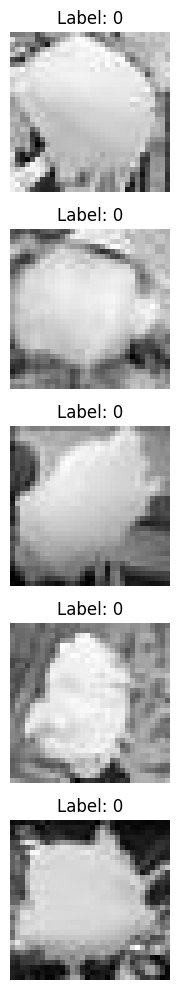

In [6]:
# Define a function to display sample images with their labels
def display_sample_images(images, labels, n=5):
    # Create a new figure for displaying the images with specified size
    plt.figure(figsize=(10, 2 * n))

    # Loop through the first 'n' images (or the maximum available if fewer)
    for i in range(min(n, len(images))):
        # Create a subplot for each image in a vertical layout
        plt.subplot(n, 1, i + 1)

        # Display the image using a grayscale colormap
        plt.imshow(images[i], cmap='gray')

        # Set the title of the subplot to show the label of the corresponding image
        plt.title(f"Label: {labels[i]}")

        # Turn off the axis to remove unnecessary ticks and labels
        plt.axis('off')

    # Automatically adjust the layout to fit the subplots
    plt.tight_layout()

    # Display the entire figure containing the sample images
    plt.show()

# Call the function to display a sample of 'n' images from the test dataset
display_sample_images(test_data, test_labels, n=5)


In [7]:

# Transformer les datas[Train, Test] à une liste
train_data = np.array(train_data)
test_data = np.array(test_data)

#Transformer les labels à  une liste
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

train_data = train_data.reshape(-1, 32*32)
test_data = test_data.reshape(-1, 32*32)

# Afficher la forme de cette image
print(train_data.shape)
print(test_data.shape)
#------------------------------------------------------------------------------------
train_data = train_data.T
test_data = test_data.T
print(train_data.shape)
print(test_data.shape)

(1348, 1024)
(202, 1024)
(1024, 1348)
(1024, 202)


It can be observed that we have about 1348 images in train data with 32*32 pixelated values and about 202 images in the test data with 32*32 pixelated values

In [8]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

# Define model architecture and hyperparameters
input_size = 32 * 32
hidden_size = 350
output_size = 3

# Initialize model parameters
def init_params():
    # Initialize weights and biases with random values
    W1 = np.random.randn(hidden_size, input_size) * np.sqrt(1. / 1024)
    B1 = np.random.randn(hidden_size, 1)
    W2 = np.random.randn(hidden_size, hidden_size) * np.sqrt(1. / 1024)
    B2 = np.random.randn(hidden_size, 1)
    W3 = np.random.randn(output_size, hidden_size) * np.sqrt(1. / 1024)
    B3 = np.random.randn(output_size, 1)
    return W1, B1, W2, B2, W3, B3

# Define activation function (tanh)
def tanh(x):
    return np.tanh(x)

# Define forward propagation
def forward_prop(W1, B1, W2, B2, W3, B3, X):
    # Calculate weighted sums and apply activation functions
    Z1 = W1.dot(X) + B1
    A1 = tanh(Z1)
    Z2 = W2.dot(A1) + B2
    A2 = tanh(Z2)
    Z3 = W3.dot(A2) + B3
    A3 = tanh(Z3)
    return Z1, A1, Z2, A2, Z3, A3

# Define one-hot encoding function
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

# Define derivative of tanh activation function
def derivative_tanh(x):
    return 1.0 - np.tanh(x) ** 2

# Define mean squared error function
def mean_squared_error(predictions, targets):
    return np.mean((predictions - targets) ** 2)

# Define backpropagation
def back_prop(Z1, A1, Z2, A2, Z3, A3, W2, W3, X, Y):
    m = Y.size
    one_hot_Y = one_hot(Y)
    dZ3 = A3 - one_hot_Y
    dW3 = (1 / m) * dZ3.dot(A2.T)
    dB3 = (1 / m) * np.sum(dZ3, axis=1, keepdims=True)
    dZ2 = W3.T.dot(dZ3) * derivative_tanh(Z2)
    dW2 = (1 / m) * dZ2.dot(A1.T)
    dB2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T.dot(dZ2) * derivative_tanh(Z1)
    dW1 = (1 / m) * dZ1.dot(X.T)
    dB1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, dB1, dW2, dB2, dW3, dB3

# Define function to update model weights and biases
def update_weights(W1, B1, W2, B2, W3, B3, dW1, dB1, dW2, dB2, dW3, dB3, learning_rate):
    W1 = W1 - learning_rate * dW1
    B1 = B1 - learning_rate * dB1
    W2 = W2 - learning_rate * dW2
    B2 = B2 - learning_rate * dB2
    W3 = W3 - learning_rate * dW3
    B3 = B3 - learning_rate * dB3
    return W1, B1, W2, B2, W3, B3

# Define function to get class predictions
def get_predictions(A3):
    return np.argmax(A3, axis=0)

# Define function to calculate accuracy
def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

# Initialize lists to store training and testing metrics
train_accuracies = []
train_costs = []
train_losses = []
test_accuracies = []
test_costs = []
test_losses = []

# Setting hyperparameters
iterations = 1000
learning_rate = 0.007
writer = SummaryWriter()

# Initialize model parameters
W1, B1, W2, B2, W3, B3 = init_params()

# Training loop
for i in range(iterations):
    # Forward propagation
    Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1, B1, W2, B2, W3, B3, train_data)

    # Backpropagation
    dW1, dB1, dW2, dB2, dW3, dB3 = back_prop(Z1, A1, Z2, A2, Z3, A3, W2, W3, train_data, train_labels)

    # Update model weights and biases
    W1, B1, W2, B2, W3, B3 = update_weights(W1, B1, W2, B2, W3, B3, dW1, dB1, dW2, dB2, dW3, dB3, learning_rate)

    if i % 50 == 0:
        # Calculate training metrics
        train_predictions = get_predictions(A3)
        train_accuracy = get_accuracy(train_predictions, train_labels)
        train_cost = np.mean((A3 - one_hot(train_labels)) ** 2) / 2
        train_loss = mean_squared_error(A3, one_hot(train_labels))

        # Append training metrics to lists
        train_accuracies.append(train_accuracy)
        train_costs.append(train_cost)
        train_losses.append(train_loss)

        # Log training metrics to TensorBoard
        writer.add_scalar('Train Accuracy', train_accuracy, i)
        writer.add_scalar('Train Cost', train_cost, i)
        writer.add_scalar('Train Loss', train_loss, i)

    # Obtain testing data
    Z1_test, A1_test, Z2_test, A2_test, Z3_test, A3_test = forward_prop(W1, B1, W2, B2, W3, B3, test_data)

    if i % 50 == 0:
        # Calculate testing metrics
        test_predictions = get_predictions(A3_test)
        test_accuracy = get_accuracy(test_predictions, test_labels)
        test_cost = np.mean((A3_test - one_hot(test_labels)) ** 2) / 2
        test_loss = mean_squared_error(A3_test, one_hot(test_labels))

        # Append testing metrics to lists
        test_accuracies.append(test_accuracy)
        test_costs.append(test_cost)
        test_losses.append(test_loss)

        # Log testing metrics to TensorBoard
        writer.add_scalar('Test Accuracy', test_accuracy, i)
        writer.add_scalar('Test Cost', test_cost, i)
        writer.add_scalar('Test Loss', test_loss, i)

        # Print metrics for monitoring
        print(f"Iteration: {i}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}, Train Cost: {train_cost}, Test Cost: {test_cost}, Train Loss: {train_loss}, Test Loss: {test_loss}")

# Close TensorBoard writer
writer.close()


Iteration: 0, Train Accuracy: 0.2381305637982196, Test Accuracy: 0.3811881188118812, Train Cost: 0.4270056867438597, Test Cost: 0.1393864013417366, Train Loss: 0.8540113734877194, Test Loss: 0.2787728026834732
Iteration: 50, Train Accuracy: 0.6060830860534124, Test Accuracy: 0.4158415841584158, Train Cost: 0.0978501734998862, Test Cost: 0.10674910866139739, Train Loss: 0.1957003469997724, Test Loss: 0.21349821732279478
Iteration: 100, Train Accuracy: 0.6364985163204748, Test Accuracy: 0.47029702970297027, Train Cost: 0.09002076401673605, Test Cost: 0.09913804916836867, Train Loss: 0.1800415280334721, Test Loss: 0.19827609833673734
Iteration: 150, Train Accuracy: 0.6520771513353115, Test Accuracy: 0.504950495049505, Train Cost: 0.08328716920079944, Test Cost: 0.09334175052548198, Train Loss: 0.16657433840159888, Test Loss: 0.18668350105096396
Iteration: 200, Train Accuracy: 0.6683976261127597, Test Accuracy: 0.5544554455445545, Train Cost: 0.07838819529972968, Test Cost: 0.0899082711174

<b>observations </b>

1. **Train Accuracy and Test Accuracy**: The training accuracy and test accuracy increase as the number of iterations increases. This indicates that the model is learning and improving its ability to classify the data correctly over time.

2. **Train Cost and Test Cost**: Both the training cost and test cost decrease as the number of iterations increases. This means that the model is becoming more confident in its predictions and is reducing its error in classifying the data. Lower cost values are desirable.

3. **Train Loss and Test Loss**: Similar to the cost, the training loss and test loss decrease as the number of iterations increases. This indicates that the model is minimizing its loss function, which is a good sign of learning. Lower loss values are desirable.

4. **Overfitting Check**: It's important to monitor the relationship between training and test metrics. In this case, the training and test metrics seem to follow a similar trend, which suggests that the model is not overfitting the training data. Overfitting occurs when the model performs well on the training data but poorly on unseen test data.

5. **Accuracy Improvement**: The model's accuracy on both the training and test datasets is improving, which suggests that the model is learning the underlying patterns in the data.


Overall, the model seems to be learning effectively and is not showing signs of overfitting.

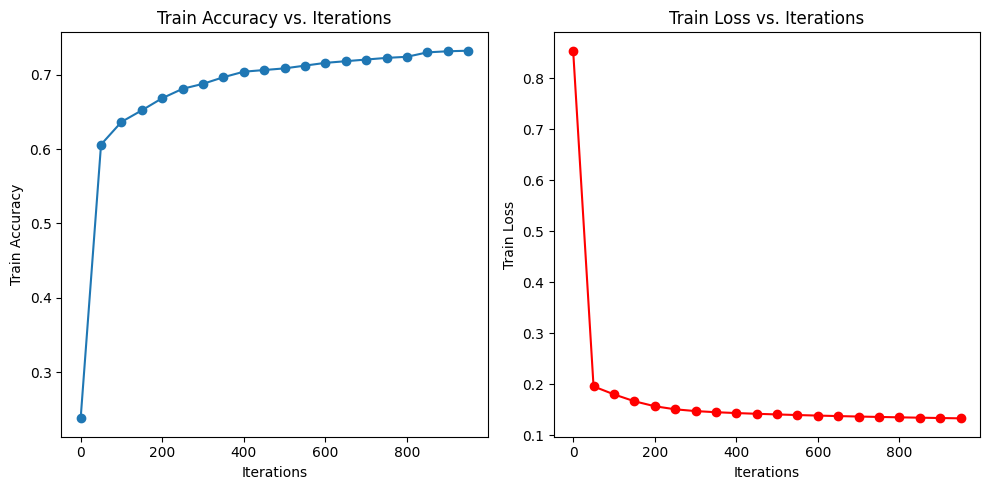

In [9]:
# Plotting accuracy graph
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(0, iterations, 50), train_accuracies, marker='o')
plt.title('Train Accuracy vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Train Accuracy')

# Plotting Loss graph
plt.subplot(1, 2, 2)
plt.plot(range(0, iterations, 50), train_losses, marker='o', color='r')
plt.title('Train Loss vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Train Loss')

plt.tight_layout()
plt.show()



- It can be observed that the model performance seems to be better as the train accuracy increases as the iterations increase and the trainloss decreases as the iterations increase

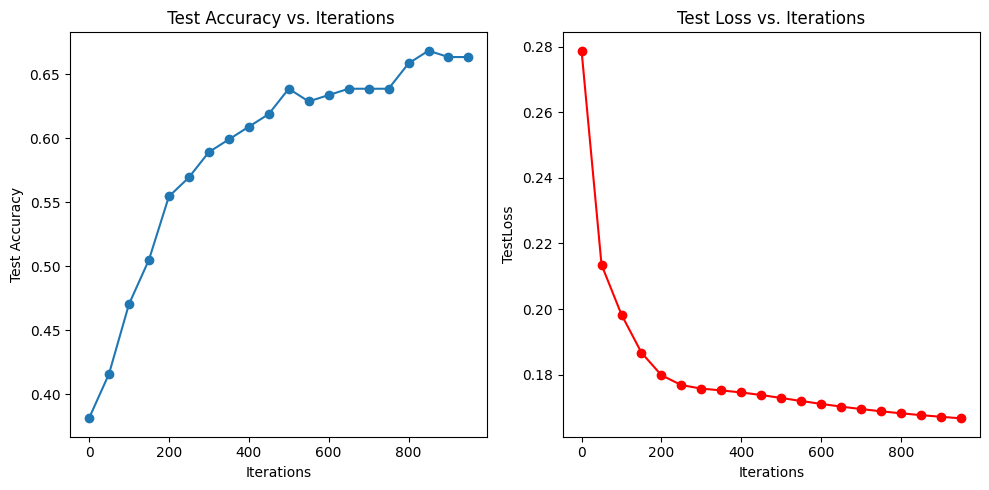

In [10]:
# Plotting Test accuracy graph
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(0, iterations, 50), test_accuracies, marker='o')
plt.title(' Test Accuracy vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Test Accuracy')

# Plotting Test Loss graph
plt.subplot(1, 2, 2)
plt.plot(range(0, iterations, 50), test_losses, marker='o', color='r')
plt.title('Test Loss vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('TestLoss')

plt.tight_layout()
plt.show()



- It can be observed that the model performance seems to be better as the test accuracy increases as the iterations increase and the test loss decreases as the iterations increase
- The test accuracy has been more than 65% and can be further improved by performing some tuning i.e. by adding more layers and more weights and using other activation functions like Tanh.

In [21]:
# %load_ext tensorboard
# %tensorboard --logdir=runs

<b> Saving the model parameters

In [13]:
# Import the pickle module for saving and loading model parameters
import pickle

# Save the model parameters using pickle
trained_model = {
    "W1": W1,     # Weight matrix for the first layer
    "B1": B1,     # Bias vector for the first layer
    "W2": W2,     # Weight matrix for the second layer
    "B2": B2,     # Bias vector for the second layer
    "W3": W3,     # Weight matrix for the third (output) layer
    "B3": B3      # Bias vector for the third (output) layer
}

# Open a file for writing in binary mode ("wb") to save the model parameters
with open("trained_model.pkl", "wb") as model_file:
    pickle.dump(trained_model, model_file)

# Print a success message after saving the model parameters
print("Model parameters saved successfully.")

# Load the model parameters using pickle
with open("trained_model.pkl", "rb") as model_file:
    loaded_model = pickle.load(model_file)

# Retrieve the loaded model parameters
loaded_W1 = loaded_model["W1"]
loaded_B1 = loaded_model["B1"]
loaded_W2 = loaded_model["W2"]
loaded_B2 = loaded_model["B2"]
loaded_W3 = loaded_model["W3"]
loaded_B3 = loaded_model["B3"]


Model parameters saved successfully.


<b> Test cases

case-1

In [24]:
import numpy as np
import pickle
from PIL import Image

# Loading the saved model
def load_model():
    with open("trained_model.pkl", "rb") as model_file:
        model = pickle.load(model_file)
    return model

# Defining the tanh activation function
def tanh(x):
    return np.tanh(x)

# Loading the saved model
model = load_model()
# Loading the image
uploaded_image = "/content/dataset/DataSet_Train/PDA_F/PDA (10).jpg"
image = Image.open(uploaded_image)

    # Process the image and make prediction
resized_image = image.resize((32, 32))
input_array = np.array(resized_image)
input_array = input_array.reshape(-1, 1)  # Reshape the image data if needed

W1, B1, W2, B2, W3, B3 = model["W1"], model["B1"], model["W2"], model["B2"], model["W3"], model["B3"]
Z1 = W1.dot(input_array) + B1
A1 = tanh(Z1)
Z2 = W2.dot(A1) + B2
A2 = tanh(Z2)
Z3 = W3.dot(A2) + B3
A3 = tanh(Z3)
prediction = np.argmax(A3)

print("Label is: ", prediction)

Label is:  1


case-2

In [25]:
import numpy as np
import pickle
from PIL import Image

# Loading the saved model
def load_model():
    with open("trained_model.pkl", "rb") as model_file:
        model = pickle.load(model_file)
    return model

# Defining the tanh activation function
def tanh(x):
    return np.tanh(x)

# Loading the saved model
model = load_model()
# Loading the image
uploaded_image = "/content/dataset/DataSet_Test/BBRP_TST/BBRP (10).jpg"
image = Image.open(uploaded_image)

    # Process the image and make prediction
resized_image = image.resize((32, 32))
input_array = np.array(resized_image)
input_array = input_array.reshape(-1, 1)  # Reshape the image data if needed

W1, B1, W2, B2, W3, B3 = model["W1"], model["B1"], model["W2"], model["B2"], model["W3"], model["B3"]
Z1 = W1.dot(input_array) + B1
A1 = tanh(Z1)
Z2 = W2.dot(A1) + B2
A2 = tanh(Z2)
Z3 = W3.dot(A2) + B3
A3 = tanh(Z3)
prediction = np.argmax(A3)

print("Label is: ", prediction)

Label is:  0


case-3

In [26]:
import numpy as np
import pickle
from PIL import Image

# Loading the saved model
def load_model():
    with open("trained_model.pkl", "rb") as model_file:
        model = pickle.load(model_file)
    return model

# Defining the tanh activation function
def tanh(x):
    return np.tanh(x)

# Loading the saved model
model = load_model()
# Loading the image
uploaded_image = "/content/dataset/DataSet_Test/BBRP_TST/BBRP (12).jpg"
image = Image.open(uploaded_image)

    # Process the image and make prediction
resized_image = image.resize((32, 32))
input_array = np.array(resized_image)
input_array = input_array.reshape(-1, 1)  # Reshape the image data if needed

W1, B1, W2, B2, W3, B3 = model["W1"], model["B1"], model["W2"], model["B2"], model["W3"], model["B3"]
Z1 = W1.dot(input_array) + B1
A1 = tanh(Z1)
Z2 = W2.dot(A1) + B2
A2 = tanh(Z2)
Z3 = W3.dot(A2) + B3
A3 = tanh(Z3)
prediction = np.argmax(A3)

print("Label is: ", prediction)

Label is:  0


In [30]:
import numpy as np
import pickle
from PIL import Image

# Loading the saved model
def load_model():
    with open("trained_model.pkl", "rb") as model_file:
        model = pickle.load(model_file)
    return model

# Defining the tanh activation function
def tanh(x):
    return np.tanh(x)

# Loading the saved model
model = load_model()
# Loading the image
uploaded_image = "/content/dataset/DataSet_Test/PDA_TST/PDA (23).jpg"
image = Image.open(uploaded_image)

    # Process the image and make prediction
resized_image = image.resize((32, 32))
input_array = np.array(resized_image)
input_array = input_array.reshape(-1, 1)  # Reshape the image data if needed

W1, B1, W2, B2, W3, B3 = model["W1"], model["B1"], model["W2"], model["B2"], model["W3"], model["B3"]
Z1 = W1.dot(input_array) + B1
A1 = tanh(Z1)
Z2 = W2.dot(A1) + B2
A2 = tanh(Z2)
Z3 = W3.dot(A2) + B3
A3 = tanh(Z3)
prediction = np.argmax(A3)

print("Label is: ", prediction)

Label is:  1
